##Data Preparation for clinical dataset

In [0]:
clinicaltrial = "clinicaltrial_2021"
pharma = "pharma"
completionyear = 2021

In [0]:
# read the CSV file into a dataframe
clinicaltrial_df = spark.read.options(delimiter="|", header = True).csv("/FileStore/tables/" + clinicaltrial + ".csv")
 
#preview the dataframe
clinicaltrial_df.show(2, truncate = False)

+-----------+---------------------------+----------+--------+----------+--------------+----------+------------------------------------------+-------------+
|Id         |Sponsor                    |Status    |Start   |Completion|Type          |Submission|Conditions                                |Interventions|
+-----------+---------------------------+----------+--------+----------+--------------+----------+------------------------------------------+-------------+
|NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021  |Interventional|Apr 2016  |null                                      |null         |
|NCT02751957|Duke University            |Completed |Jul 2016|Jul 2020  |Interventional|Apr 2016  |Autistic Disorder,Autism Spectrum Disorder|null         |
+-----------+---------------------------+----------+--------+----------+--------------+----------+------------------------------------------+-------------+
only showing top 2 rows



##Question 1 - Pyspark Dataframe

In [0]:
from pyspark.sql.functions import count, column
 
# count the distinct number of studies in the dataframe
NumberOfDistinctstudies = clinicaltrial_df.select(column("Id")).distinct().count()
 
print(NumberOfDistinctstudies)

387261


##Question 2 - Pyspark Dataframe

In [0]:
#group by type column and count, then order by the count column in descending order
FrequencyTypes_df = clinicaltrial_df.groupBy("Type").count().orderBy(column("count").desc())
 
FrequencyTypes_df.show(truncate=False)

+--------------------------------+------+
|Type                            |count |
+--------------------------------+------+
|Interventional                  |301472|
|Observational                   |77540 |
|Observational [Patient Registry]|8180  |
|Expanded Access                 |69    |
+--------------------------------+------+



##Question 3 - Pyspark Dataframe

In [0]:
from pyspark.sql.functions import split, explode, col
 
# Filter out null values from the conditions column, Split the Conditions column by comma delimiter and explode the resulting array
# Group by Condition and count the frequency of each condition
# Sort by frequency in descending order and take the top 5
 
TopFiveConditions = (
  clinicaltrial_df.filter(column("Conditions").isNotNull())
  .select(explode(split(column("Conditions"), ",")))
  .groupBy(column("col").alias("Condition")).count()
  .orderBy(column("count").desc())
  .limit(5)
)
 
#Display the resulting Dataframe
TopFiveConditions.show(truncate = False )

+-----------------+-----+
|Condition        |count|
+-----------------+-----+
|Carcinoma        |13389|
|Diabetes Mellitus|11080|
|Neoplasms        |9371 |
|Breast Neoplasms |8640 |
|Syndrome         |8032 |
+-----------------+-----+



##Data Preparation for pharma dataset

In [0]:
pharma = "pharma"

In [0]:
# read the CSV file into a dataframe 
Pharmaceuticals_df = spark.read.options(delimiter= ",", header = True).csv("/FileStore/tables/" + pharma + ".csv") 

In [0]:
#View the dataframe Schema
Pharmaceuticals_df.printSchema()

root
 |-- Company: string (nullable = true)
 |-- Parent_Company: string (nullable = true)
 |-- Penalty_Amount: string (nullable = true)
 |-- Subtraction_From_Penalty: string (nullable = true)
 |-- Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting: string (nullable = true)
 |-- Penalty_Year: string (nullable = true)
 |-- Penalty_Date: string (nullable = true)
 |-- Offense_Group: string (nullable = true)
 |-- Primary_Offense: string (nullable = true)
 |-- Secondary_Offense: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Level_of_Government: string (nullable = true)
 |-- Action_Type: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Civil/Criminal: string (nullable = true)
 |-- Prosecution_Agreement: string (nullable = true)
 |-- Court: string (nullable = true)
 |-- Case_ID: string (nullable = true)
 |-- Private_Litigation_Case_Title: string (nullable = true)
 |-- Lawsuit_Resolution: string (nullable = true)
 |-- Facility_State: string (

In [0]:
#View the parent company field required to answer the question
Pharmaceuticals_df.select('Parent_Company').show(truncate= False)

+----------------------+
|Parent_Company        |
+----------------------+
|Abbott Laboratories   |
|AbbVie                |
|AbbVie                |
|Abbott Laboratories   |
|Johnson & Johnson     |
|Abbott Laboratories   |
|Abbott Laboratories   |
|Johnson & Johnson     |
|Johnson & Johnson     |
|Abbott Laboratories   |
|AbbVie                |
|AbbVie                |
|Pfizer                |
|Pfizer                |
|Bristol-Myers Squibb  |
|Amgen                 |
|Amgen                 |
|Amgen                 |
|Amneal Pharmaceuticals|
|Astellas Pharma       |
+----------------------+
only showing top 20 rows



##QUESTION 4 - PySpark Dataframe

In [0]:
from pyspark.sql.functions import collect_list, desc
 
# Collect all distinct parent companies into a list
pharmaceutical_companies = Pharmaceuticals_df.select("Parent_Company").distinct() \
    .agg(collect_list("Parent_Company")) \
    .first()[0]
 
# Filter out clinical trials sponsored by pharmaceutical companies
sponsor_counts = clinicaltrial_df.filter(~column("Sponsor").isin(pharmaceutical_companies)) \
    .groupBy("Sponsor").count() \
    .orderBy(col("count").desc()) \
    .limit(10)
 
#show the result
sponsor_counts.show(truncate =False)

+---------------------------------------+-----+
|Sponsor                                |count|
+---------------------------------------+-----+
|National Cancer Institute (NCI)        |3218 |
|M.D. Anderson Cancer Center            |2414 |
|Assistance Publique - Hôpitaux de Paris|2369 |
|Mayo Clinic                            |2300 |
|Merck Sharp & Dohme Corp.              |2243 |
|Assiut University                      |2154 |
|Novartis Pharmaceuticals               |2088 |
|Massachusetts General Hospital         |1971 |
|Cairo University                       |1928 |
|Hoffmann-La Roche                      |1828 |
+---------------------------------------+-----+



##Question 5 - Pyspark Dataframe

In [0]:
from pyspark.sql.functions import to_date, year, month, date_format
 
#Filter by completed trials and required year
completedTrialsDF = clinicaltrial_df \
                    .filter((clinicaltrial_df.Status == "Completed") & (year(to_date(clinicaltrial_df.Completion, "MMM yyyy")) == completionyear))
 
#Count completed trials per month
completedCountsDF = completedTrialsDF \
                    .groupBy(date_format(to_date(completedTrialsDF.Completion, "MMM yyyy"), "MMM").alias("Month")) \
                    .count() \
 
#Define a dictionary to map the month names to their corresponding numbers
MonthsDictionary = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}
 
#Sort the result by month using the dictionary and drop the MonthNumber column
CompletedTrialsPerMonth = completedCountsDF \
    .withColumn("MonthNumber", month(to_date("Month", "MMM")).cast("int")) \
    .orderBy("MonthNumber") \
    .drop("MonthNumber")

In [0]:
# Show result
CompletedTrialsPerMonth.show()

+-----+-----+
|Month|count|
+-----+-----+
|  Jan| 1131|
|  Feb|  934|
|  Mar| 1227|
|  Apr|  967|
|  May|  984|
|  Jun| 1094|
|  Jul|  819|
|  Aug|  700|
|  Sep|  528|
|  Oct|  187|
+-----+-----+



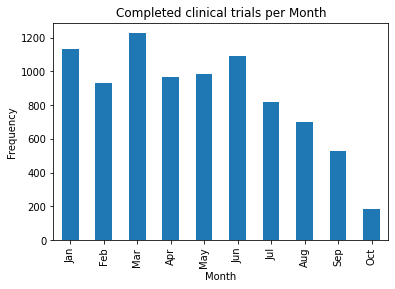

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
 
#Convert PySpark DataFrame to pandas DataFrame
CompletedTrialsPerMonth_df = CompletedTrialsPerMonth.toPandas()
 
#set the 'Month' column as the index
CompletedTrialsPerMonth_df.set_index('Month', inplace=True)
 
#plot the frequency by month
ax = CompletedTrialsPerMonth_df.plot(kind='bar', legend=None)
ax.set_ylabel('Frequency')
ax.set_xlabel('Month')
ax.set_title('Completed clinical trials per Month')
plt.show()

##EXTRA FEATURES

#Problem statement
#Examine the annual trend in the number of penalties imposed on pharmceutical companies

In [0]:
from pyspark.sql.functions import count
 
#Create a Df with the required column
Penalty_year_df = Pharmaceuticals_df.select("Penalty_year")
 
#aggregate by "Penalty_year"
Penalty_year_df = Penalty_year_df.groupBy("Penalty_year") \
                                 .agg(count("*").alias("Penalty_Count_Per_Year")) \
                                 .orderBy("Penalty_year")
 
#show the Penalty_year_df dataframe
Penalty_year_df.show()

+------------+----------------------+
|Penalty_year|Penalty_Count_Per_Year|
+------------+----------------------+
|        2000|                    38|
|        2001|                    24|
|        2002|                    26|
|        2003|                    33|
|        2004|                    41|
|        2005|                    32|
|        2006|                    37|
|        2007|                    45|
|        2008|                    43|
|        2009|                    70|
|        2010|                    81|
|        2011|                    67|
|        2012|                    61|
|        2013|                    77|
|        2014|                    44|
|        2015|                    42|
|        2016|                    45|
|        2017|                    43|
|        2018|                    30|
|        2019|                    47|
+------------+----------------------+
only showing top 20 rows



##VISUALISATION

In [0]:
#Convert the Penalty year column to Date type
Penalty_year_df = Penalty_year_df.withColumn('Penalty_year', to_date(Penalty_year_df['Penalty_year'], 'yyyy'))

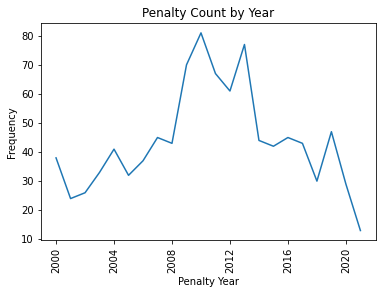

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
 
#convert to Pandas DataFrame for plotting
Penalty_plot = Penalty_year_df.toPandas()
 
#create a line plot
plt.plot(Penalty_plot["Penalty_year"], Penalty_plot["Penalty_Count_Per_Year"])
 
#set the plot title and axis labels
plt.title('Penalty Count by Year')
plt.xlabel('Penalty Year')
plt.ylabel('Frequency')
 
#rotate the x-axis tick labels
plt.xticks(rotation=90)
 
#display the plot
plt.show()